In [75]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tools.eval_measures import meanabs, rmse, mse

In [23]:
df1 = pd.read_csv('Data/DailyTotalFemaleBirths.csv',index_col=0,parse_dates=True)
df1 = df1[:120]
df1.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [24]:
df1.shape

(120, 1)

In [25]:
df1.index.freq = 'D'

In [26]:
df2 = pd.read_csv('Data/TradeInventories.csv',index_col=0,parse_dates=True)
df2.head()

,Inventories
Date,
1997-01-01,1301161
1997-02-01,1307080
1997-03-01,1303978
1997-04-01,1319740
1997-05-01,1327294


In [27]:
df2.shape

(264, 1)

In [28]:
df2.index.freq = 'MS'

## ARMA

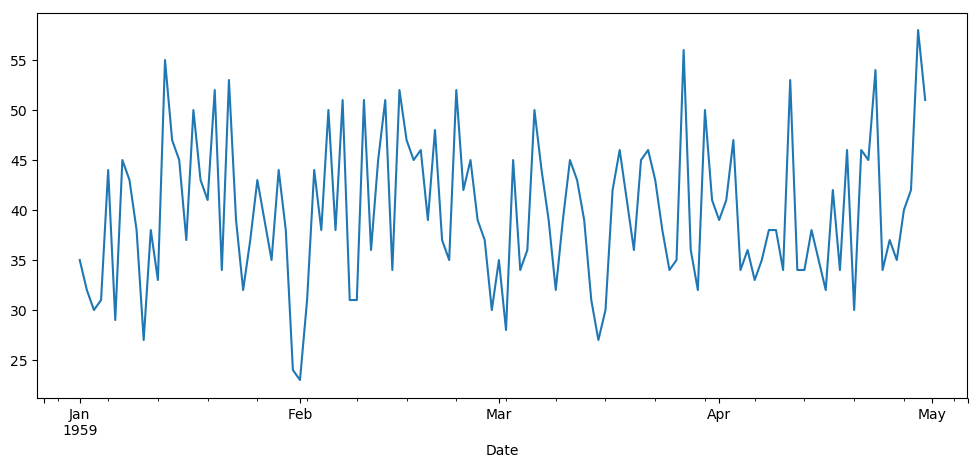

In [29]:
df1['Births'].plot(figsize=(12,5));

In [30]:
def adf_test(series,title=''):
    print(f"Augmented Dickey-Fuller Test: {title}")
    adf_results = adfuller(series.dropna(),autolag='AIC')
    df_results = pd.Series(adf_results[:4],index=['test-statistic','p-value','# lags','# observations'])
    
    for key, val in adf_results[4].items():
        df_results[f'critical_value({key})'] = val
    
    print(df_results.to_string())
    
    if adf_results[1] <= 0.05:
        print("Strong evidence against null hypothesis.")
        print("We reject the null hypothesis.")
        print("Data has no unit root and is stationary.")
    else:
        print("Weak evidence against null hypothesis.")
        print("We fail to reject the null hypothesis.")
        print("Data has a unit root and is non-stationary.")

In [31]:
adf_test(df1['Births'])

Augmented Dickey-Fuller Test: 
test-statistic        -9.855384e+00
p-value                4.373545e-17
# lags                 0.000000e+00
# observations         1.190000e+02
critical_value(1%)    -3.486535e+00
critical_value(5%)    -2.886151e+00
critical_value(10%)   -2.579896e+00
Strong evidence against null hypothesis.
We reject the null hypothesis.
Data has no unit root and is stationary.


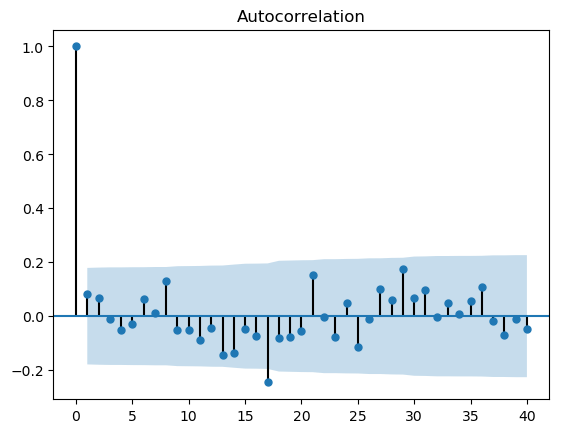

In [32]:
plot_acf(df1['Births'],lags=40);

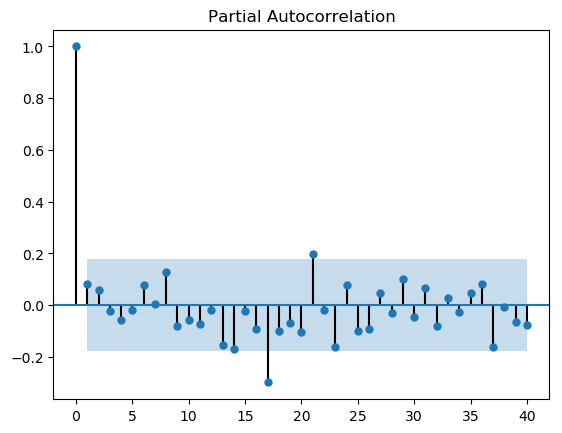

In [33]:
plot_pacf(df1['Births'],lags=40);

In [36]:
auto_arima(df1['Births'],seasonal=False,suppress_warnings=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                     ARMA(2, 2)   Log Likelihood                -405.370
Method:                       css-mle   S.D. of innovations              6.991
Date:                Fri, 20 Sep 2024   AIC                            822.741
Time:                        19:51:40   BIC                            839.466
Sample:                             0   HQIC                           829.533
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.8163      0.108    368.927      0.000      39.605      40.028
ar.L1.y        1.8569      0.081     22.944      0.000       1.698       2.016
ar.L2.y       -0.8815      0.073    -12.037      0.000      -1.025      -0.738
ma.L1.y       -1.8634      0.109    -17.131      0.000      -2.077      -1.650
ma.L2.y        0.8634      0.108      8.023      0.000       0.652       1.074
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0533           -0.1582j            1.0651           -0.0237
AR.2            1.0533           +0.1582j            1.0651            0.0237
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2            1.1582           +0.0000j            1.1582            0.0000
-----------------------------------------------------------------------------
"""

In [38]:
train_data = df1.iloc[:90]
test_data = df1.iloc[90:]

In [40]:
model = ARMA(train_data['Births'],order=(2,2))
results = model.fit()

In [42]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Births   No. Observations:                   90
Model:                     ARMA(2, 2)   Log Likelihood                -307.905
Method:                       css-mle   S.D. of innovations              7.405
Date:                Fri, 20 Sep 2024   AIC                            627.809
Time:                        19:57:08   BIC                            642.808
Sample:                    01-01-1959   HQIC                           633.858
                         - 03-31-1959                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           39.7549      0.912     43.607      0.000      37.968      41.542
ar.L1.Births    -0.1850      1.087     -0.170      0.865      -2.315       1.945
ar.L2.Births     0.4352      0.644      0.675      0.501      -0.828       1.698
ma.L1.Births     0.2777      1.097      0.253      0.801      -1.872       2.427
ma.L2.Births    -0.3999      0.679     -0.589      0.557      -1.730       0.930
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3181           +0.0000j            1.3181            0.5000
AR.2            1.7433           +0.0000j            1.7433            0.0000
MA.1           -1.2718           +0.0000j            1.2718            0.5000
MA.2            1.9662           +0.0000j            1.9662            0.0000
-----------------------------------------------------------------------------
"""

In [43]:
results.params

const           39.754889
ar.L1.Births    -0.185030
ar.L2.Births     0.435163
ma.L1.Births     0.277700
ma.L2.Births    -0.399906
dtype: float64

In [46]:
test_predictions = results.predict(start=len(train_data),end=len(train_data)+len(test_data)-1)
test_predictions = test_predictions.rename('ARMA(2,2) Predictions')
test_predictions

1959-04-01    39.982216
1959-04-02    39.992614
1959-04-03    39.809827
1959-04-04    39.848173
1959-04-05    39.761536
1959-04-06    39.794253
1959-04-07    39.750498
1959-04-08    39.772831
1959-04-09    39.749658
1959-04-10    39.763665
1959-04-11    39.750989
1959-04-12    39.759430
1959-04-13    39.752352
1959-04-14    39.757334
1959-04-15    39.753333
1959-04-16    39.756241
1959-04-17    39.753962
1959-04-18    39.755649
1959-04-19    39.754345
1959-04-20    39.755321
1959-04-21    39.754572
1959-04-22    39.755135
1959-04-23    39.754706
1959-04-24    39.755030
1959-04-25    39.754783
1959-04-26    39.754970
1959-04-27    39.754828
1959-04-28    39.754936
1959-04-29    39.754854
1959-04-30    39.754916
Freq: D, Name: ARMA(2,2) Predictions, dtype: float64

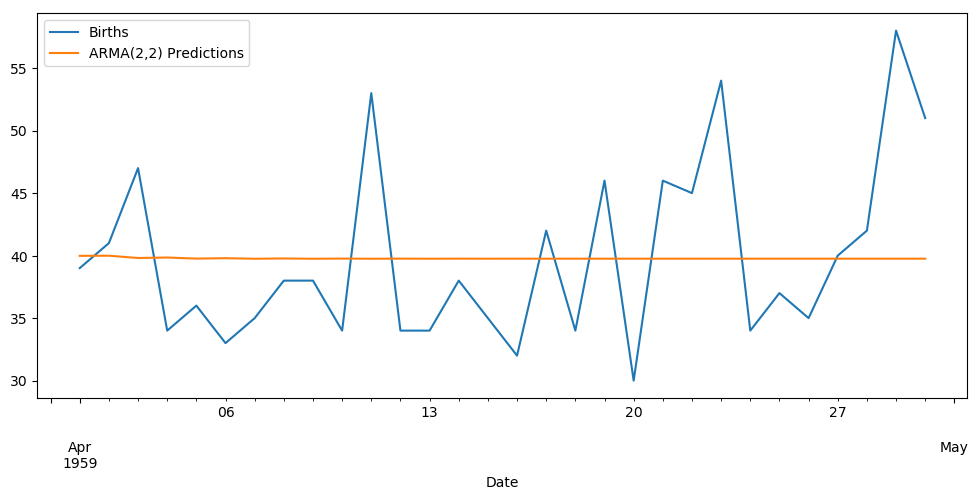

In [49]:
test_data.plot(figsize=(12,5),legend=True)
test_predictions.plot(legend=True);

In [50]:
test_predictions.mean()

39.77743188846464

In [52]:
test_data.Births.mean()

39.833333333333336

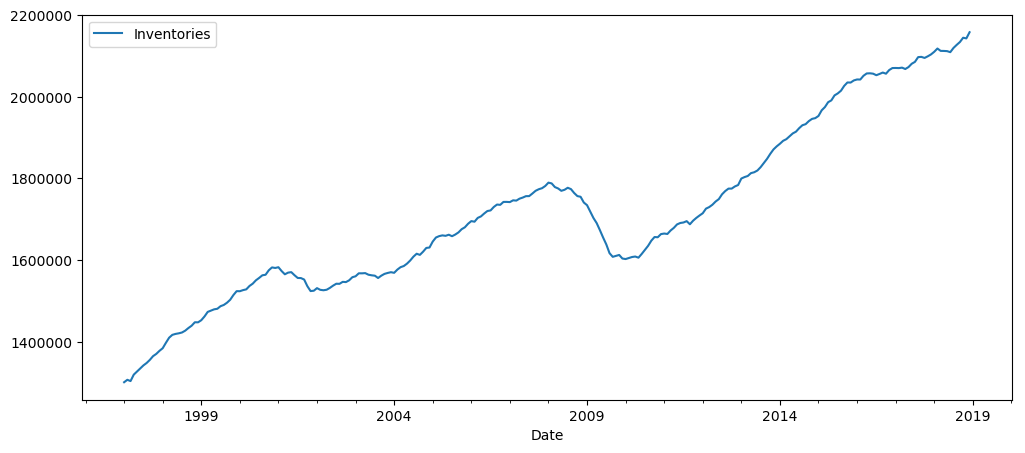

In [53]:
df2.plot(figsize=(12,5));

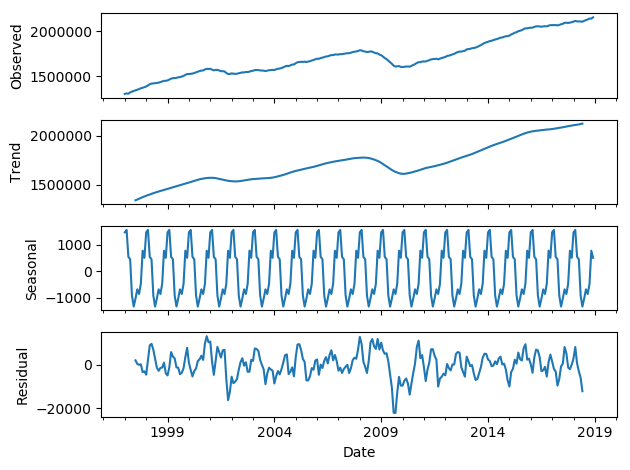

In [56]:
results = seasonal_decompose(df2['Inventories'],model='additive')
results.plot();

In [57]:
auto_arima(df2['Inventories'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2610.252
Method:                       css-mle   S.D. of innovations           4938.258
Date:                Fri, 20 Sep 2024   AIC                           5228.505
Time:                        21:05:46   BIC                           5242.794
Sample:                             1   HQIC                          5234.247
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3472.9857   1313.669      2.644      0.009     898.241    6047.731
ar.L1.D.y      0.9037      0.039     23.414      0.000       0.828       0.979
ma.L1.D.y     -0.5732      0.076     -7.545      0.000      -0.722      -0.424
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1065           +0.0000j            1.1065            0.0000
MA.1            1.7446           +0.0000j            1.7446            0.0000
-----------------------------------------------------------------------------
"""

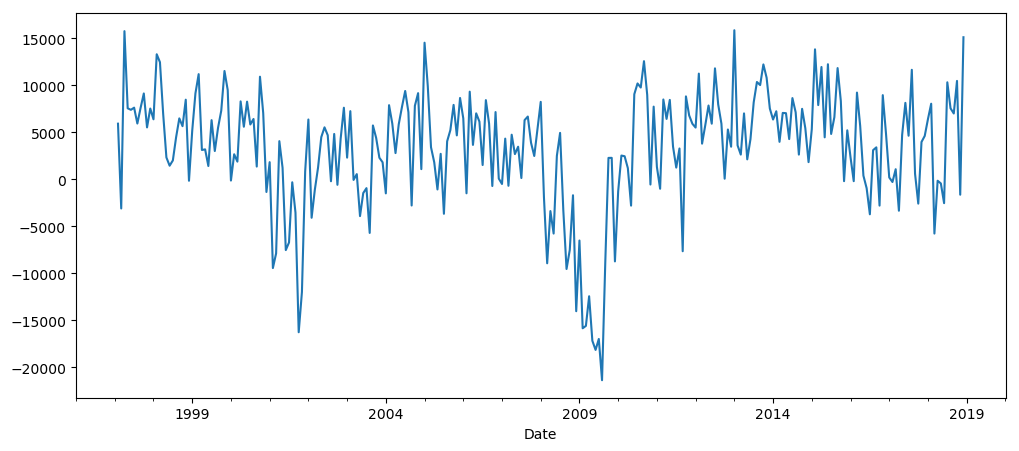

In [60]:
df2['Diff_1'] = diff(df2['Inventories'],k_diff=1)
df2.Diff_1.plot(figsize=(12,5));

In [61]:
adf_test(df2['Diff_1'])

Augmented Dickey-Fuller Test: 
test-statistic          -3.412249
p-value                  0.010548
# lags                   4.000000
# observations         258.000000
critical_value(1%)      -3.455953
critical_value(5%)      -2.872809
critical_value(10%)     -2.572775
Strong evidence against null hypothesis.
We reject the null hypothesis.
Data has no unit root and is stationary.


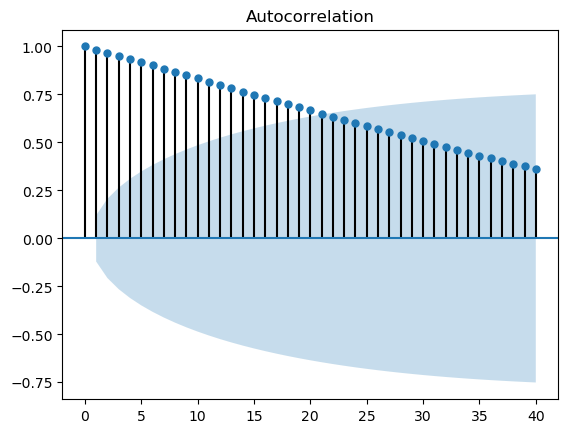

In [63]:
plot_acf(df2['Inventories'],lags=40);

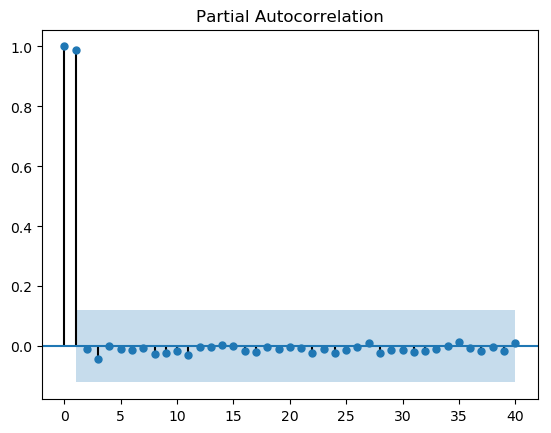

In [64]:
plot_pacf(df2['Inventories'],lags=40);

In [65]:
stepwise_fit = auto_arima(df2['Inventories'],start_p=0,start_q=0,max_p=2,max_q=2,seasonal=False,suppress_warnings=False,trace=True)
stepwise_fit

Fit ARIMA: order=(0, 1, 0); AIC=5348.037, BIC=5355.181, Fit time=0.017 seconds
Fit ARIMA: order=(1, 1, 0); AIC=5250.883, BIC=5261.599, Fit time=0.059 seconds
Fit ARIMA: order=(0, 1, 1); AIC=5283.095, BIC=5293.811, Fit time=0.024 seconds
Fit ARIMA: order=(2, 1, 0); AIC=5240.553, BIC=5254.842, Fit time=0.127 seconds
Fit ARIMA: order=(2, 1, 1); AIC=5229.528, BIC=5247.389, Fit time=0.245 seconds
Fit ARIMA: order=(1, 1, 1); AIC=5228.505, BIC=5242.794, Fit time=0.144 seconds
Fit ARIMA: order=(1, 1, 2); AIC=5229.289, BIC=5247.150, Fit time=0.386 seconds
Fit ARIMA: order=(2, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 1.131 seconds


ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=None, solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend=None,
   with_intercept=True)

In [66]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2610.252
Method:                       css-mle   S.D. of innovations           4938.258
Date:                Fri, 20 Sep 2024   AIC                           5228.505
Time:                        21:21:27   BIC                           5242.794
Sample:                             1   HQIC                          5234.247
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3472.9857   1313.669      2.644      0.009     898.241    6047.731
ar.L1.D.y      0.9037      0.039     23.414      0.000       0.828       0.979
ma.L1.D.y     -0.5732      0.076     -7.545      0.000      -0.722      -0.424
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1065           +0.0000j            1.1065            0.0000
MA.1            1.7446           +0.0000j            1.7446            0.0000
-----------------------------------------------------------------------------
"""

In [67]:
df2.shape

(264, 2)

In [68]:
train = df2[:252]
test = df2[252:]

In [70]:
train.shape, test.shape

((252, 2), (12, 2))

In [72]:
model = ARIMA(train['Inventories'],order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Inventories   No. Observations:                  251
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2486.395
Method:                       css-mle   S.D. of innovations           4845.028
Date:                Fri, 20 Sep 2024   AIC                           4980.790
Time:                        21:25:56   BIC                           4994.892
Sample:                    02-01-1997   HQIC                          4986.465
                         - 12-01-2017                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3197.5697   1344.871      2.378      0.018     561.671    5833.468
ar.L1.D.Inventories     0.9026      0.039     23.010      0.000       0.826       0.979
ma.L1.D.Inventories    -0.5581      0.079     -7.048      0.000      -0.713      -0.403
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1080           +0.0000j            1.1080            0.0000
MA.1            1.7918           +0.0000j            1.7918            0.0000
-----------------------------------------------------------------------------
"""

In [74]:
test_predictions = results.predict(start=len(train),end=len(train)+len(test)-1,typ='levels')
test_predictions

2018-01-01    2.107148e+06
2018-02-01    2.110526e+06
2018-03-01    2.113886e+06
2018-04-01    2.117231e+06
2018-05-01    2.120561e+06
2018-06-01    2.123878e+06
2018-07-01    2.127184e+06
2018-08-01    2.130479e+06
2018-09-01    2.133764e+06
2018-10-01    2.137041e+06
2018-11-01    2.140311e+06
2018-12-01    2.143573e+06
Freq: MS, dtype: float64

In [80]:
print("MAE:",meanabs(test.Inventories,test_predictions))
print("MSE:",mse(test.Inventories,test_predictions))
print("RMSE:",rmse(test.Inventories,test_predictions))

MAE: 6376.313462885718
MSE: 60677824.72190262
RMSE: 7789.597211788464


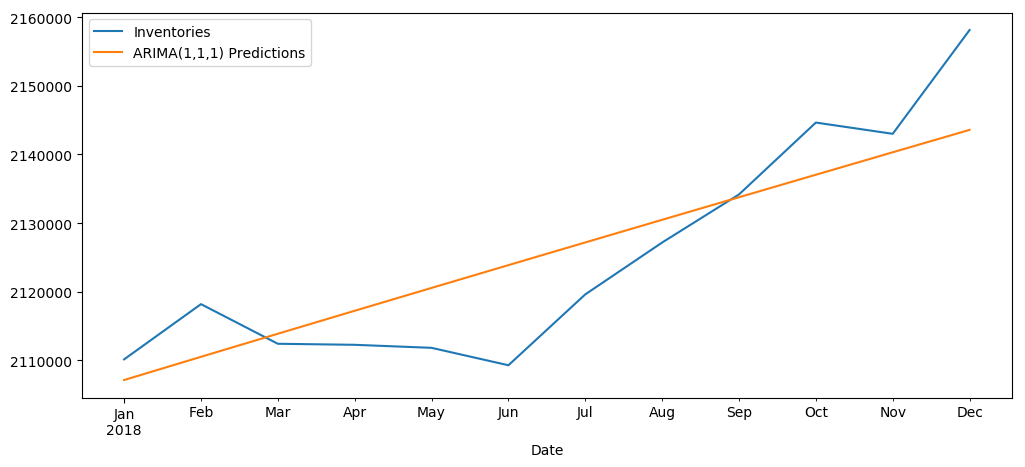

In [81]:
test['Inventories'].plot(figsize=(12,5),legend=True)
test_predictions.plot(legend=True,label='ARIMA(1,1,1) Predictions');

In [84]:
test.Inventories.mean()

2125075.6666666665

In [83]:
test_predictions.mean()

2125465.270731611

### Forecast into unknown future

In [86]:
model = ARIMA(df2['Inventories'],order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Inventories   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2610.252
Method:                       css-mle   S.D. of innovations           4938.258
Date:                Fri, 20 Sep 2024   AIC                           5228.505
Time:                        21:38:12   BIC                           5242.794
Sample:                    02-01-1997   HQIC                          5234.247
                         - 12-01-2018                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3472.9857   1313.669      2.644      0.009     898.241    6047.731
ar.L1.D.Inventories     0.9037      0.039     23.414      0.000       0.828       0.979
ma.L1.D.Inventories    -0.5732      0.076     -7.545      0.000      -0.722      -0.424
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1065           +0.0000j            1.1065            0.0000
MA.1            1.7446           +0.0000j            1.7446            0.0000
-----------------------------------------------------------------------------
"""

In [89]:
forecast = results.predict(start=len(df2),end=len(df2)+len(test)-1,typ='levels')
forecast

2019-01-01    2.165609e+06
2019-02-01    2.172716e+06
2019-03-01    2.179473e+06
2019-04-01    2.185914e+06
2019-05-01    2.192069e+06
2019-06-01    2.197966e+06
2019-07-01    2.203630e+06
2019-08-01    2.209082e+06
2019-09-01    2.214344e+06
2019-10-01    2.219434e+06
2019-11-01    2.224368e+06
2019-12-01    2.229162e+06
Freq: MS, dtype: float64

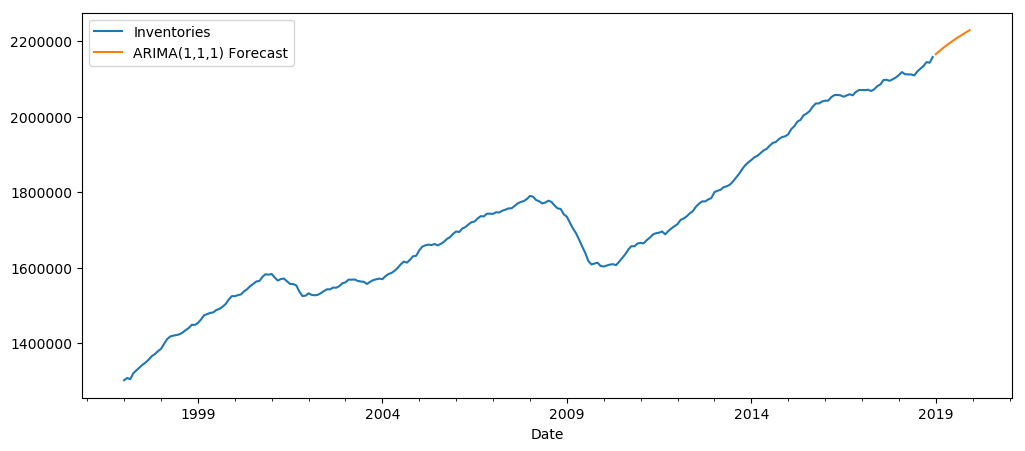

In [91]:
df2['Inventories'].plot(figsize=(12,5),legend=True)
forecast.plot(legend=True,label='ARIMA(1,1,1) Forecast');